# Remote Sensing Practical using Google Earth Engine

Run this notebook in a new environment by running the following in the terminal:

```
conda create --name remote-sensing

conda activate remote-sensing

pip install jupyter
pip install matplotlib
pip install ee
pip install earthengine-api
pip install folium

jupyter lab
```

### Import relevant libraries

In [141]:
from IPython.display import Image
import matplotlib.pyplot as plt
import folium
import numpy as np

### Authenticate Google Earth Engine
But first, create a GEE account if you don't have one already: https://earthengine.google.com/

In [2]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code:  4/1AfJohXl4o4hlVj1l3L1lVfD6U0x3sLUG8hVw5cKPobleoQQHkaOw6_tGtT0



Successfully saved authorization token.


# Part 1 - Download and Display a Multispectral Image 🛰️

### Define area of interest
* Use Google Maps to get the point coordinate of somewhere in central London
* Note that Google Maps default is (lat,lon) but for GEE we need to use (lon,lat)

In [3]:
london_coords = (51.51353, -0.11206) # latitude, longitude

# Create a point
london_point = ee.Geometry.Point(london_coords[::-1]) # longitude, latitude

# Create a 10km buffer around the point, and get a bounding box
london = london_point.buffer(10000).bounds()

### Download a multispectral image for the area
* In Google Earth Engine, data is organised in collections; each collection many images (from different places and different time periods). We are usually interested in one (or a few) images in the collection only
* Use the Search bar in Google Earth Engine to find your preferred provider (Landsat, Sentinel...). We'll use Landsat 9, Collection 2, Tier 1, TOA Reflectance which is `LANDSAT/LC09/C02/T1_TOA`
* TOA indicates that the data was top-of-atmosphere calibrated, meaning the atmospheric noise was removed
* We can narrow down a collection using filters, such as `filterBounds()`, `filterDate`, filter by cloud coverage, etc
* Once we define the criteria, we can get a random image from the subset of images that satisfy the criteria. Alternatively, we can extract the least cloudy image

In [4]:
# First, define your collection
l9_collection = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA')

# Then, load a single representative image from the collection
l9_img = ee.Image(
    l9_collection
    .filterBounds(london) # get only those images that contain our boundary for London
    .filterDate('2023-01-01', '2023-12-31') # get images from 2023
    .filter( ee.Filter.lt('CLOUD_COVER', 10) )
    .sort('CLOUD_COVER') # sort in ascending order by cloud cover
    .first() # get the first image only (least cloudy)
    .clip(london) # clip to the London area extent
)

### List all available bands
Use Google Earth Engine GUI (Description and Band tabs) to learn what each band is

For Landsat 9,
* B2 = Blue
* B3 = Green
* B4 = Red
* B5 = Near infrared (NIR)
* B6 and B7 are shortwave infrared (SWIR)

In [5]:
l9_img.bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9',
 'B10',
 'B11',
 'QA_PIXEL',
 'QA_RADSAT',
 'SAA',
 'SZA',
 'VAA',
 'VZA']

### Create a true-color composite image and show on map
* We can combine red, green, and blue band balues to create a true-colour composite image
* Use `folium` to place the raster image on an interactive map

In [6]:
# Define a method for displaying Earth Engine image tiles to folium map
# Adapted from https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1
def add_ee_layer(self, ee_image_object, vis_params):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        overlay = True
    ).add_to(self)

# Add EE drawing method to folium
folium.Map.add_ee_layer = add_ee_layer

In [7]:
red = l9_img.select('B4')
green = l9_img.select('B3')
blue = l9_img.select('B2')

rgb_img = ee.Image.rgb(red, green, blue)

In [8]:
# Create the map object
m1 = folium.Map(location=london_coords, zoom_start=11)

# Add the layer
m1.add_ee_layer(rgb_img, {
    'min': 0,
    'max': 0.25
})

# Display the map
m1

### Excercise 1 🗺️

Create a true-colour composite layer for a place of your choice (not London) using a Sentinel collection. Display it in a Folium map

# Part 2. Calculating Normalised Difference Vegetation Index 🌳

Remember the formula for NDVI is: 

`NDVI = (NIR - Red) / (NIR + Red)`

And in Landsat 9 imagery, NIR is band B5, and Red is Band B4

In [9]:
nir = l9_img.select('B5')

In [10]:
ndvi = nir.subtract(red).divide( nir.add(red) )
ndvi_img = ee.Image(ndvi)

In [13]:
m2 = folium.Map(location=london_coords, zoom_start=11)

m2.add_ee_layer(ndvi_img, {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
})

# Display the map
m2

#### Let's now create a mask to only show pixels with high NDVI
* This should give us a raster layer of parks and other green areas
* Try changing the default (0.45) value

In [14]:
ndvi_img_mask = ndvi_img.mask(ndvi_img.gt(0.45))

m3 = folium.Map(location=london_coords, zoom_start=11)

m3.add_ee_layer(ndvi_img_mask, {
    'min': -1,
    'max': 1,
    'palette': ['green']
})

m3

### Exercise 2 💧

Create a *Normalised Difference Water Index* for your study area from Exercise 1, and plot it in a folium map

# Part 3 - Change Detection using Simple Difference 🕵️‍♀️

Let's take two images, the least cloudy one from Jan-March 2023 and the least cloudy one from June-Aug 2023, and detect changes in NDVI using simple difference between the index values.

In [70]:
l9_img_2022 = ee.Image(
    l9_collection
    .filterBounds(london) # get only those images that contain our boundary for London
    .filterDate('2022-05-01', '2023-09-30') # get images from summer 2022
    .sort('CLOUD_COVER') # sort in ascending order by cloud cover
    .first() # get the first image only (least cloudy)
    .clip(london) # clip to the London area extent
)

l9_img_2023 = ee.Image(
    l9_collection
    .filterBounds(london) # get only those images that contain our boundary for London
    .filterDate('2023-05-01', '2023-09-30') # get images from summer 2023
    .sort('CLOUD_COVER') # sort in ascending order by cloud cover
    .first() # get the first image only (least cloudy)
    .clip(london) # clip to the London area extent
)

### Let's see which images we got
* Display cloud cover and dates for both images

In [203]:
def get_img_info(img):
    return (
        'Image from '
        + img.date().format('Y-M-d').getInfo()
        + ' with the cloud cover of '
        + str(img.get('CLOUD_COVER').getInfo())
        + '%'
    )

In [204]:
get_img_info(l9_img_2022)

'Image from 2022-8-10 with the cloud cover of 0.03%'

In [205]:
get_img_info(l9_img_2023)

'Image from 2023-9-7 with the cloud cover of 0.26%'

In [110]:
# Calculate NDVI indices using a built-in function
ndvi_2022 = l9_img_2022.normalizedDifference(['B5', 'B4'])
ndvi_2023 = l9_img_2023.normalizedDifference(['B5', 'B4'])

# Subtract the two
ndvi_diff = ndvi_2023.subtract(ndvi_2022)

In [206]:
# Let's get a sample of the NDVI difference values into a 1D numpy array
values_2d = np.array(
    ndvi_diff.sampleRectangle(
        region=london_point.buffer(2000)
    )
    .getInfo()
    ['properties']
    ['nd']
)

values_1d = values_2d.reshape(-1)

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 5.000e+00, 8.000e+00,
        1.100e+01, 1.200e+01, 3.300e+01, 3.900e+01, 6.000e+01, 7.900e+01,
        1.280e+02, 1.810e+02, 2.440e+02, 3.460e+02, 5.450e+02, 7.410e+02,
        1.068e+03, 1.584e+03, 2.332e+03, 2.870e+03, 2.650e+03, 1.847e+03,
        1.149e+03, 7.760e+02, 5.030e+02, 3.290e+02, 2.090e+02, 1.320e+02,
        7.900e+01, 4.200e+01, 2.900e+01, 1.700e+01, 1.000e+01, 8.000e+00,
        7.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-0.65402448, -0.63054072, -0.60705695, -0.58357319, -0.56008943,
        -0.53660566, -0.5131219 , -0.48963813, -0.46615437, -0.44267061,
        -0.41918684, -0.39570308, -0.37221931, -0.34873555, -0.32525179,
        -0.30176802, -0.27828426, -0.25480049, -0.23131673, -0.20783297,
        -0.1843492 , -0.16086544, -0.13738168, -0.11389791, -0.09041415,
        -0.

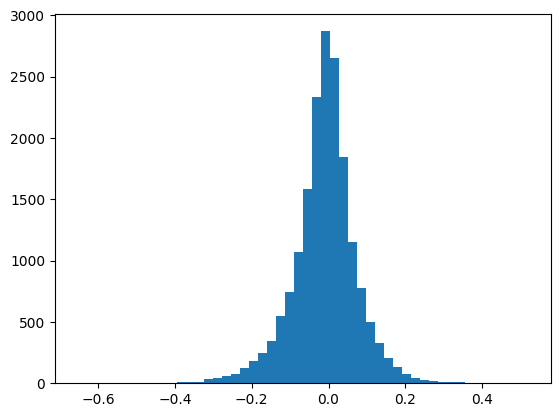

In [207]:
plt.hist(values_1d, bins=50)

* We can see the difference values are more or less normally distributed around 0
* Let's plot values of 0.2+ in blue to signify areas with more vegetation in 2023
* Let's plot values of less than 0.2 in red to represent areas with less vegetation in 2023

In [216]:
m4 = folium.Map(location=london_coords, zoom_start=11)

# Create a general vegetation mask - let's consider 2023 NDVI values of 0.3+ as vegetation
veg_mask = ndvi_2023.gt(0.3)

# Increased vegetation mask
veg_increase_mask = ndvi_diff.gt(0.2)

# Decreased vegetation mask
veg_decrease_mask = ndvi_diff.lt(-0.2)

# Let's plot these in different colours
m4.add_ee_layer(
    ndvi_diff.updateMask(veg_mask).updateMask(veg_increase_mask),
    {'palette': ['red'] }
)

m4.add_ee_layer(
    ndvi_diff.updateMask(veg_mask).updateMask(veg_decrease_mask),
    {'palette': ['blue'] }
)

m4

### Exercise 3

Create a simple difference map for the NDWI values for the two time periods for your area of choice